# Liver Model Construction: Notebook

In [1]:
import os
import re
import warnings
from cobra.io.json import load_json_model as load_json_cobra_model
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite
import cobra.test
from os.path import join
from mass.util import qcqa
from mass.util import qcqa_model
from cobra import DictList
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile
from mass.visualization import (
    plot_ensemble_phase_portrait, plot_ensemble_time_profile)
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)
from cobra.io.json import *
import cobra_dict as c_d
import csv


MASSpy version: 0.1.1


In [2]:
maps_dir = os.path.abspath("../massters_model/maps")
data_dir = os.path.abspath("../massters_model/data")
extra_dir=os.path.abspath("../massters_model")

### Loading Reaction and Metabolite data from files

In [3]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [4]:
# making dataframe 
csv_rxn = os.path.join(data_dir,"rxn_df")
csv_met = os.path.join(data_dir,"met_df")
rxn_csv_df = pd.read_csv(csv_rxn) 
met_csv_df = pd.read_csv(csv_met,index_col="id")
met_csv_df=met_csv_df.drop("Unnamed: 0",axis=1)
metabolite_info=met_csv_df.to_dict(orient='index')


In [5]:
# rxn_info = load_data(
#     filepath=csv_rxn,
#     sheet_name="Sheet1")
# rxn_info

In [6]:
# Loading reaction and metabolite data from Excel file, converting them to dictionaries
# data_sheet_met=os.path.join(data_dir,"metabolite_info.xlsx")

# met_info = load_data(
#     filepath=data_sheet_met,
#     sheet_name="Sheet1")
# # .drop("notes", axis=1).drop("annotation", axis=1)
# metabolite_info=met_info.to_dict(orient='index')



# data_sheet_rxn=os.path.join(data_dir,"reactions_info.xlsx")
# rxn_info = load_data(
#     filepath=data_sheet_rxn,
#     sheet_name="Sheet1")
# reactions_info=rxn_info.to_dict(orient='index')

In [7]:
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.csv")
ic_df = pd.read_csv(csv_ic)
# ic_df

In [8]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
with open(r'/home/mass_user/massters_model/data/rxn') as json_file:
    rxn_data = json.load(json_file)

## Making MASS model of glycolysis

In [9]:
liver= MassModel("Core Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model

In [10]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [11]:
for reaction, info in rxn_data.items():
    print(reaction)
    reaction_obj = MassReaction(reaction)
    reaction_obj.id=info['id']
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)

HEX1: atp_c + glc__D_c --> adp_c + g6p_c + h_c
PGI: g6p_c <=> f6p_c
PFK: atp_c + f6p_c --> adp_c + fdp_c + h_c
FBP: fdp_c + h2o_c --> f6p_c + pi_c
FBA: fdp_c <=> dhap_c + g3p_c
TPI: dhap_c <=> g3p_c
GAPD: g3p_c + nad_c + pi_c <=> 13dpg_c + h_c + nadh_c
PGK: 3pg_c + atp_c <=> 13dpg_c + adp_c
PGM: 2pg_c <=> 3pg_c
ENO: 2pg_c <=> h2o_c + pep_c
PYK: adp_c + h_c + pep_c --> atp_c + pyr_c
ATPM: atp_c + h2o_c --> adp_c + h_c + pi_c
DM_nadh: nadh_c --> h_c + nad_c


In [12]:
liver.reactions.PGM.reverse_stoichiometry(inplace=True)
liver.reactions.PGM

Reaction identifier,PGM
Name,Phosphoglycerate mutase
Memory address,0x07ff30609acd0
Subsystem,
Kinetic Reversibility,True
Stoichiometry,3pg_c <=> 2pg_c 3-Phospho-D-glycerate <=> D-Glycerate 2-phosphate
GPR,
Bounds,"(-1000.0, 1000.0)"


In [13]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGK

Reaction identifier,PGK
Name,Phosphoglycerate kinase
Memory address,0x07ff30609ab50
Subsystem,
Kinetic Reversibility,True
Stoichiometry,13dpg_c + adp_c <=> 3pg_c + atp_c 3-Phospho-D-glyceroyl phosphate + ADP C10H12N5O10P2 <=> 3-Phospho-D-glycerate + ATP C10H12N5O13P3
GPR,
Bounds,"(-1000.0, 1000.0)"


In [14]:
def _replace_compartment_id(self, sep="_", new_cid=None):
        """Remove or replace the compartment from the ID str of the metabolite."""
        # Return the identifier as is if no compartment is defined.
        if not self.compartment:
            return self.id

        new_id = self.id.rpartition(sep + str(self.compartment))[0]
        if new_cid is not None:
            new_id = sep.join((new_id, new_cid))
        
        return new_id

In [15]:
## Creating reactions for gluconeogenesis

# G6P = MassReaction(
#     "G6P",
#     name="glucose 6-phosphatase",
#     reversible=False)
# G6P.add_metabolites({
    
#     liver.metabolites.get_by_id('g6p_c'): -1,
#     liver.metabolites.get_by_id('h2o_c'): -1,
#     liver.metabolites.get_by_id('pi_c') : 1,
#     liver.metabolites.get_by_id('glc__D_c'): 1})



# liver.add_reactions([
#    G6P ])

### Getting Standard and Physiological Gibbs energies of reactions

In [16]:
reaction_str= []

cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import exp as exp




for reaction in liver.reactions:
    rxn_name = reaction.id        
    reaction_str = reaction.reaction.split(" <=> ")
    reactants = reaction_str[0]
    reactants = reactants.split(" + ")

    for i in range(len(reactants)):
        string = reactants[i]
        l = len(string)
        reactants[i] = string[:l-2]
        reactants[i]= "bigg.metabolite:" + reactants[i]
    reactants_string= " + ".join(reactants)
    reactants_string = str(reactants_string + " = ")   



    products = reaction_str[1]
    products = products.split(" + ")

    for i in range(len(products)):
        string = products[i]
        l = len(string)
        products[i] = string[:l-2]            
        products[i]= "bigg.metabolite:" + products[i]
    products_string= ' + '.join(products)
    reaction_to_parse = reactants_string + products_string         
    rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)

    print(rxn_name)
    dG0_prime = cc.standard_dg_prime(rxn_parsed)
#         print(f"ΔG'° = {dG0_prime}")

    dGm_prime = cc.physiological_dg_prime(rxn_parsed)
    dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
    dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
    delG = dG_prime_value_in_kj_per_mol
    reaction.Keq = exp( -delG/ (R*310.15))   

HEX1
ΔG'm = -21.9425318095752
PGI
ΔG'm = 2.722131456515797
PFK
ΔG'm = -18.780112912199343
FBP
ΔG'm = -30.04924828167703
FBA
ΔG'm = 4.6934109500842425
TPI
ΔG'm = 5.607630168832998
GAPD
ΔG'm = 18.83682125474597
PGK
ΔG'm = -19.526821345149187
PGM
ΔG'm = 4.533264115649047
ENO
ΔG'm = -3.7806913773820554
PYK
ΔG'm = -23.835531588279366
ATPM
ΔG'm = -48.8293611938766
DM_nadh
ΔG'm = -67.41311195443768


### Adding exchange reactions

In [17]:
for met in [
#     'co2_m', 'gdp_m', 'gtp_m', 'pi_m', 'hco3_m','h_m','atp_c','atp_m'
    'glc__D_c','h_c','h2o_c','pi_c','pyr_c'
           ]:
    rxn = MassReaction('EX_%s' % met)
    liver.add_reaction(rxn)
    rxn.add_metabolites({met: -1})
    if met == 'glc__D_c':
        rxn.lower_bound = -1 # negative exchange flux = uptake
    elif met == 'pyr_c':
        rxn.lower_bound = 0
    else:
        rxn.lower_bound = -1000
        



In [18]:
# liver.reactions.L_LACt2r.lower_bound=-1
# liver.reactions.PYRt2.lower_bound=-1
# # liver.reactions.GLCt1.lower_bound=-1
# liver.reactions.Ht.lower_bound=-1000
# liver.reactions.H2Ot.lower_bound=-1000
# liver.reactions.PIt.lower_bound=-1000


In [19]:
liver.metabolites.h_c.charge= 1
# liver.metabolites.h_e.charge= 1
liver.metabolites.pi_c.charge= -2
# liver.metabolites.pi_e.charge= -2
# trial.metabolites.pi_m.charge= -2
# trial.metabolites.h_m.charge= 1

In [20]:
liver.objective = 'ATPM'
flux_solution = liver.optimize()
flux_solution


,fluxes,reduced_costs
HEX1,1.0,0.0
PGI,1.0,0.0
PFK,1.0,0.0
FBP,0.0,-2.0
FBA,1.0,0.0
...,...,...
EX_glc__D_c,-1.0,-4.0
EX_h_c,6.0,0.0
EX_h2o_c,0.0,0.0
EX_pi_c,0.0,0.0


## Escher FBA

In [21]:
#Escher FBA: shows the solutions on the map
flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}

#view all the reactions that we need build
escher_builder = escher.Builder(
    model=liver,
    map_json=os.path.join(
        maps_dir, ".".join((
            "Glycolysis", "json"))
    ), reaction_data=flux_data)

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 1.0, 'PGI': 1.0, 'PFK': 1.0, 'FBP': 0.0, 'FBA': 1.0, 'TPI': 1.0, 'GAPD': 2.0, '…

### Set fluxes

In [22]:
reaction_list = liver.reactions
for reaction, flux in flux_solution.fluxes.items():
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux # have to check conversions 
    # * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

v_HEX1: 1.0
v_PGI: 1.0
v_PFK: 1.0
v_FBP: 0.0
v_FBA: 1.0
v_TPI: 1.0
v_GAPD: 2.0
v_PGK: -2.0
v_PGM: -2.0
v_ENO: 2.0
v_PYK: 2.0
v_ATPM: 2.0
v_DM_nadh: 2.0
v_EX_glc__D_c: -1.0
v_EX_h_c: 6.0
v_EX_h2o_c: 0.0
v_EX_pi_c: 0.0
v_EX_pyr_c: 2.0


In [23]:
#Function to add underscore in front of metabolite identifiers which start with a number
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [24]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

## Setting initial conditions

In [30]:
import csv
 
# opening the CSV file
with open(csv_ic, mode ='r')as file:
   
  # reading the CSV file
    csvFile = csv.reader(file)
 
      # displaying the contents of the CSV file
    for name, value in csvFile:
        met_id = liver.metabolites.get_by_id(name)
        met_id.ic = float(value) #M
        print(met_id, ":", met_id.ic)
        print(name,value)

g6p_c : 0.00014
g6p_c 0.00014
f6p_c : 0.000127138
f6p_c 0.000127138
fdp_c : 5.15e-05
fdp_c 5.15E-05
g3p_c : 8.78e-06
g3p_c 8.78E-06
dhap_c : 0.000176897
dhap_c 0.000176897
_3pg_c : 0.00052063
_3pg_c 0.00052063
_2pg_c : 0.000110561
_2pg_c 0.000110561
pep_c : 0.00031
pep_c 0.00031
pyr_c : 0.00048
pyr_c 0.00048
atp_c : 0.004727146
atp_c 0.004727146
adp_c : 0.001994952
adp_c 0.001994952
nad_c : 0.00182531
nad_c 0.00182531
nadh_c : 4.64e-06
nadh_c 4.64E-06
pi_c : 0.0064
pi_c 0.0064


## Set H2O/H Constants

In [31]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h_c",
#     'h_e','h_m',
#     'h2o_r','h2o_e',
    "h2o_c",
#     "glc__D_e", "pi_e",'pi_m',
    'pi_c'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [32]:
for metabolite in [
#     'h_m',
"h_c", 
#     'h_e',
"h2o_c",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M
# glycogenolysis.metabolites.glc__D_e.ic=0.00001

In [33]:
for metabolite in liver.metabolites:
    print("{0}: {1}".format(metabolite.id, metabolite.ic))

adp_c: 0.001994952
atp_c: 0.004727146
g6p_c: 0.00014
glc__D_c: None
h_c: 1
f6p_c: 0.000127138
fdp_c: 5.15e-05
h2o_c: 1
pi_c: 0.0064
dhap_c: 0.000176897
g3p_c: 8.78e-06
_13dpg_c: None
nad_c: 0.00182531
nadh_c: 4.64e-06
_3pg_c: 0.00052063
_2pg_c: 0.000110561
pep_c: 0.00031
pyr_c: 0.00048


In [34]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h_c",
#         'h_e', 'h_m',
#     'h2o_r','h2o_e',
        "h2o_c",
#     "pi_e",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
#     excluded_reactions=["Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1','PYRt2m','PEPtm',
#     'L_LACt2r','PYRt2'],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

['FBP']
['FBP']


,variables,reduced_costs
adp_c,1.994952e-03,0.0
atp_c,4.727146e-03,0.0
g6p_c,2.690030e-04,0.0
glc__D_c,6.222346e-08,0.0
f6p_c,6.616775e-05,0.0
...,...,...
Keq_PGM,1.374968e-01,0.0
Keq_ENO,4.850112e+00,0.0
Keq_PYK,1.033329e+04,0.0
Keq_ATPM,1.673212e+08,0.0


In [35]:
import openpyxl

In [36]:
#Compare Results
csv_ic = os.path.join(data_dir,"Concentrations_Glycolysis.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df
ic_info = load_data(
    filepath=csv_ic,
    sheet_name="Sheet1")
ic_info 

,Concentrations in M
Glycolysis,
glc__D_c,NaN
g6p_c,0.000140
f6p_c,0.000127
fdp_c,0.000051
g3p_c,0.000009
dhap_c,0.000177
_13dpg_c,NaN
_3pg_c,NaN
_2pg_c,NaN


mass/visualization/visualization_util.py:1270 UserWarning: Ignoring {'lac__L_c', 'glc__D_c', 'h2o_c', 'h_c', '_13dpg_c', 'amp_c', '_2pg_c', '_3pg_c'}, only in one set of given values


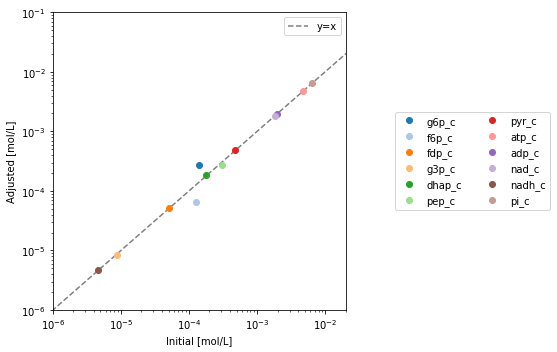

In [37]:


conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=ic_info["Concentrations in M"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in ic_info.index], ax=ax,
    legend="right outside", plot_function="loglog",
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True);

In [38]:
liver.reactions.EX_glc__D_c.Keq = 1
liver.reactions.EX_h_c.Keq = 1 
liver.reactions.EX_h2o_c.Keq = 1 
liver.reactions.EX_pi_c.Keq = 1 
liver.reactions.EX_pyr_c.Keq = 1 

In [39]:
# liver.reactions.EX_glc__D_c.kf= 1000

In [40]:
liver.boundary_conditions['glc__D_b']=0.010482807 ##M ## initial condition of the metabolite in the model
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=0.0064 ##M
liver.boundary_conditions['pi_b']=0.010482807 ##M
liver.boundary_conditions['pyr_b']=0.00048 ##M

In [41]:
Boundary= [
             "EX_glc__D_c", 
            "EX_h_c", 
            "EX_h2o_c",
            'EX_pyr_c',
            'EX_pi_c'
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [42]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
#                         or r== liver.reactions.GLCter or r== glycogenolysis.reactions.PIter
#                                or r== glycogenolysis.reactions.G6Pter or r== glycogenolysis.reactions.PIt or 
#                                 r== glycogenolysis.reactions.PYRt2m or 
#                                 r== glycogenolysis.reactions.L_LACt2r or 
#                                 r== glycogenolysis.reactions.PYRt2 or 
#                                 r== glycogenolysis.reactions.PEPtm or r== glycogenolysis.reactions.GLCt1 
#                                 or r== glycogenolysis.reactions.Ht
                       )
},
                      update_reactions=True)

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

Forward Rate Constants
----------------------
kf_HEX1: 5378323667.414316
kf_PGI: 5880.889782
kf_PFK: 3197810.159310
kf_FBP: 100000.000000
kf_FBA: 19421.090807
kf_TPI: 8446.086453
kf_GAPD: 32662020847.812023
kf_PGK: 2000727181.352774
kf_PGM: 2803.163593
kf_ENO: 20387.120284
kf_PYK: 3621918.881906
kf_ATPM: 423.088265
kf_DM_nadh: 431034.483510
kf_EX_glc__D_c: 1000000.000000
kf_EX_h_c: 1000000.000000
kf_EX_h2o_c: 1000000.000000
kf_EX_pi_c: 1000000.000000
kf_EX_pyr_c: 1000000.000000


In [43]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)



╒══════════════════════════════════════════════╕
│ MODEL ID: Core Model                         │
│ SIMULATABLE: True                            │
│ PARAMETERS NUMERICALY CONSISTENT: True       │
╞══════════════════════════════════════════════╡
│ ============================================ │
│             CONSISTENCY CHECKS               │
│ ============================================ │
│ Elemental                                    │
│ ----------------------                       │
│ DM_nadh: {charge: 2.0}                       │
│ ============================================ │
╘══════════════════════════════════════════════╛


In [44]:
# Setup simulation object
simG=Simulation(liver, verbose=False)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e2))
# Quickly render and display time profiles
conc_sol.view_time_profile()

ERROR: Error encountered trying to  <set model id>.
ERROR:mass.io.sbml:Error encountered trying to  <set model id>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR:mass.io.sbml:LibSBML error code -4: A value passed as an argument to the method is not of a type that is valid for the operation or kind of object involved. For example, this return code is used when a calling program attempts to set an SBML object identifier to a string whose syntax does not conform to the SBML identifier syntax.
ERROR: Error encountered trying to  <set model meta id>.
ERROR:mass.io.sbml:Error encountered trying to  <set model meta id>.
ERROR: LibSBML error code -4: A value passed as an argument to the method is not of a type t

AttributeError: 'NoneType' object has no attribute 'createFluxObjective'

In [ ]:
liver.metabolites.atp_c.summary()

In [ ]:
from cobra.flux_analysis import flux_variability_analysis

In [ ]:
flux_variability_analysis(liver, liver.reactions[:])

In [ ]:
liver.optimize()
liver.summary(fva=0.95)

In [ ]:
cobra.flux_analysis.flux_variability_analysis(
    liver, liver.reactions[:], fraction_of_optimum=0.9)

### Export

In [ ]:
save_json_mass_model(
    mass_model=liver,
    filename=os.path.join(extra_dir, liver.id + ".json"))